Importação das Bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

Montar drive no Google Colab

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Definição de parâmetros

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5

# Parâmetros de divisão do dataset
TRAIN_SPLIT = 0.7     # 70% para treino
VAL_SPLIT = 0.15      # 15% para validação
TEST_SPLIT = 0.15     # 15% para teste

# Verificação de segurança para garantir que os splits somam 1
assert abs(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT - 1.0) < 1e-9, "Os splits devem somar 1"

Preparação dos dados

In [4]:
def prepare_data(data_dir, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT):

    validation_split = (val_split + test_split) / (train_split + val_split + test_split)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=validation_split
    )

    # Gerador para dados de teste (apenas rescale)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de treino
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=42
    )

    # Carregar dados de validação e teste
    temp_val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=42
    )

    # Ajustar a proporção entre validação e teste
    val_ratio = val_split / (val_split + test_split)
    n_val = int(len(temp_val_generator.filenames) * val_ratio)
    
    # Criar geradores separados para validação e teste
    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=42,
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print(f"\nDivisão do dataset:")
    print(f"Treino: {len(train_generator.filenames)} imagens ({train_split*100:.1f}%)")
    print(f"Validação: {n_val} imagens ({val_split*100:.1f}%)")
    print(f"Teste: {len(temp_val_generator.filenames) - n_val} imagens ({test_split*100:.1f}%)")

    return train_generator, validation_generator, test_generator

Criar o modelo com Transfer Learning

In [5]:
def create_model():
    # Carregar o modelo base MobileNetV2 pré-treinado
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congelar as camadas do modelo base
    base_model.trainable = False

    # Criar o modelo completo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        # 1 neurônio para classificação binária
        layers.Dense(5, activation='softmax')
    ])

    return model

Treinar o modelo

In [6]:
def train_model(model, train_generator, validation_generator):
    # Compilar o modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Treinar o modelo
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator
    )

    return history

Treina e avalia uma Random Forest para comparação

In [7]:
def train_random_forest(train_generator, test_generator):
    """
    Treina e avalia uma Random Forest para comparação
    """
    # Preparar dados para Random Forest
    X_train = []
    y_train = []

    for i in range(len(train_generator)):
        batch_x, batch_y = train_generator[i]
        X_train.extend(batch_x.reshape(batch_x.shape[0], -1))
        y_train.extend(np.argmax(batch_y, axis=1))

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Treinar Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Preparar dados de teste
    X_test = []
    y_test = []

    for i in range(len(test_generator)):
        batch_x, batch_y = test_generator[i]
        X_test.extend(batch_x.reshape(batch_x.shape[0], -1))
        y_test.extend(np.argmax(batch_y, axis=1))

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Fazer predições
    y_pred_rf = rf.predict(X_test)
    y_pred_proba_rf = rf.predict_proba(X_test)

    # Calcular métricas
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    roc_auc_rf = {}
    for i in range(5):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
        roc_auc_rf[i] = auc(fpr, tpr)

    return {
        'confusion_matrix': cm_rf,
        'roc': roc_auc_rf,
        'report': classification_report(y_test, y_pred_rf, target_names=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']),
        'model': rf
    }

Funções para visualização de resultados

In [8]:
results_folder = 'results/'


def plot_training_history(history, save_path=results_folder):
    """
    Plota o histórico de treinamento com estilo aprimorado
    """
    plt.figure(figsize=(15, 5))

    # Plot Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color='#2ecc71',
             label='Treino', linewidth=2)
    plt.plot(history.history['val_accuracy'], color='#e74c3c',
             label='Validação', linewidth=2)
    plt.title('Acurácia do Modelo', fontsize=14, pad=15)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color='#2ecc71',
             label='Treino', linewidth=2)
    plt.plot(history.history['val_loss'], color='#e74c3c',
             label='Validação', linewidth=2)
    plt.title('Perda do Modelo', fontsize=14, pad=15)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Perda', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(cm, save_path=results_folder):
    """
    Plota matriz de confusão estilizada
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Matriz de Confusão', fontsize=14, pad=15)
    plt.colorbar()

    classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Adicionar valores na matriz
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Real', fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc, save_path=results_folder):
    """
    Plota curva ROC estilizada
    """
    plt.figure(figsize=(8, 6))
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='#e74c3c', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Curva ROC', fontsize=14, pad=15)
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def compare_models(cnn_results, rf_results, save_path='results'):
    """
    Compara os resultados do CNN e Random Forest
    Assume que:
    - cnn_results['roc'] é uma tupla de (fpr_dict, tpr_dict, auc_dict)
    - rf_results['roc'] é um dicionário
    """
    plt.figure(figsize=(12, 8))

    # Extraindo os dados ROC do CNN
    fpr_dict, tpr_dict, roc_auc_dict = cnn_results['roc']

    # Plotando curvas ROC para CNN
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, (label, color) in enumerate(zip(fpr_dict.keys(), colors)):
        fpr = fpr_dict[label]
        tpr = tpr_dict[label]
        roc_auc = roc_auc_dict[label]
        plt.plot(fpr, tpr,
                 label=f'CNN - Classe {label} (AUC = {roc_auc:.2f})',
                 color=color, linestyle='-', linewidth=2, alpha=0.7)

    # Plotando curvas ROC para Random Forest (assumindo estrutura de dicionário)
    rf_roc = rf_results['roc']
    for i, (label, values) in enumerate(rf_roc.items()):
        if isinstance(values, dict):
            fpr = values.get('fpr', [])
            tpr = values.get('tpr', [])
            roc_auc = values.get('auc', 0)
        else:
            continue

        plt.plot(fpr, tpr,
                 label=f'RF - Classe {label} (AUC = {roc_auc:.2f})',
                 color=colors[i], linestyle='--', linewidth=2, alpha=0.7)

    # Configurações do gráfico
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.title('Comparação das Curvas ROC (CNN vs Random Forest)',
              fontsize=14, pad=15)
    plt.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)

    # Salvando o gráfico
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.close()


def inspect_roc_structure(roc_data, model_name=""):
    """
    Função auxiliar para inspecionar a estrutura dos dados ROC
    """
    print(f"\nInspecionando estrutura ROC - {model_name}")
    if isinstance(roc_data, tuple):
        print("ROC é uma tupla com comprimento:", len(roc_data))
        for i, item in enumerate(roc_data):
            print(f"Item {i}:")
            print("  Tipo:", type(item))
            if isinstance(item, dict):
                print("  Chaves:", item.keys())
                for k, v in item.items():
                    print(f"    {k}: tipo={type(v)}, ", end="")
                    if hasattr(v, 'shape'):
                        print(f"shape={v.shape}")
                    else:
                        print(f"len={len(v)}")
    elif isinstance(roc_data, dict):
        print("ROC é um dicionário com chaves:", roc_data.keys())
        for k, v in roc_data.items():
            print(f"Chave {k}:")
            print("  Tipo:", type(v))
            if isinstance(v, dict):
                print("  Subchaves:", v.keys())


# Função auxiliar para debugar a estrutura dos resultados
def debug_results_structure(cnn_results, rf_results):
    """
    Função para analisar a estrutura dos resultados
    """
    print("\nEstrutura dos resultados CNN:")
    print("Chaves disponíveis:", cnn_results.keys())
    print("\nEstrutura do ROC CNN:")
    print("Tipo:", type(cnn_results['roc']))
    print("Comprimento:", len(cnn_results['roc']))
    if isinstance(cnn_results['roc'], (list, tuple)):
        for i, item in enumerate(cnn_results['roc']):
            print(f"Item {i}:", type(item), item.shape if hasattr(
                item, 'shape') else len(item))

    print("\nEstrutura dos resultados RF:")
    print("Chaves disponíveis:", rf_results.keys())
    print("\nEstrutura do ROC RF:")
    print("Tipo:", type(rf_results['roc']))
    print("Comprimento:", len(rf_results['roc']))
    if isinstance(rf_results['roc'], (list, tuple)):
        for i, item in enumerate(rf_results['roc']):
            print(f"Item {i}:", type(item), item.shape if hasattr(
                item, 'shape') else len(item))

Mostra informações detalhadas sobre os conjuntos de dados

In [9]:
def show_dataset_info(train_generator, val_generator, test_generator):
    """
    Mostra informações detalhadas sobre os conjuntos de dados
    """
    total_images = (len(train_generator.filenames) +
                    len(val_generator.filenames) +
                    len(test_generator.filenames))

    num_classes = len(train_generator.class_indices)

    print("\n" + "="*50)
    print("INFORMAÇÕES DO DATASET".center(50))
    print("="*50)

    print(f"\nTotal de imagens: {total_images}")
    print(f"Quantidade de classes: {num_classes}")

    # Informações do conjunto de treino
    print("\n" + "-"*20 + " TREINO " + "-"*20)
    print(f"Total: {len(train_generator.filenames)} imagens")
    print(f"Proporção: {len(train_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(train_generator.class_indices.keys(),
                          np.bincount(train_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens ({
              count/len(train_generator.filenames):.1%})")

    # Informações do conjunto de validação
    print("\n" + "-"*20 + " VALIDAÇÃO " + "-"*20)
    print(f"Total: {len(val_generator.filenames)} imagens")
    print(f"Proporção: {len(val_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(val_generator.class_indices.keys(),
                          np.bincount(val_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens ({count/len(val_generator.filenames):.1%})")

    # Informações do conjunto de teste
    print("\n" + "-"*20 + " TESTE " + "-"*20)
    print(f"Total: {len(test_generator.filenames)} imagens")
    print(f"Proporção: {len(test_generator.filenames)/total_images:.1%}")
    class_dist = dict(zip(test_generator.class_indices.keys(),
                          np.bincount(test_generator.classes)))
    for cls, count in class_dist.items():
        print(f"{cls}: {count} imagens ({count/len(test_generator.filenames):.1%})")
    print("\n" + "="*50)

Função para avaliar o modelo

In [10]:
def evaluate_model(model, test_generator):
    """
    Avalia o modelo usando várias métricas
    """
    # Fazer predições
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcular ROC e AUC para cada classe
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(test_generator.class_indices)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gerar relatório de classificação
    report = classification_report(
        y_true, y_pred, target_names=test_generator.class_indices.keys())

    return {
        'confusion_matrix': cm,
        'roc': (fpr, tpr, roc_auc),
        'report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'predictions': predictions
    }

Calcula as métricas de avaliação do modelo


In [11]:
def calculate_metrics(y_true, y_pred):
    """
    Calcula as métricas de avaliação do modelo
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    metrics = {}

    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision +
                                                    sensitivity) if (precision + sensitivity) > 0 else 0

        metrics[i] = {
            'Acurácia': accuracy,
            'Sensibilidade': sensitivity,
            'Especificidade': specificity,
            'Precisão': precision,
            'F-score': f1_score
        }

    return metrics


def plot_detailed_metrics(metrics, class_names, save_path='results'):
    """
    Gera visualizações detalhadas das métricas
    """
    os.makedirs(save_path, exist_ok=True)

    # Preparando dados para visualização
    metric_names = ['Acurácia', 'Sensibilidade',
                    'Especificidade', 'Precisão', 'F-score']
    metrics_data = np.zeros((len(class_names), len(metric_names)))

    for i in range(len(class_names)):
        for j, metric in enumerate(metric_names):
            metrics_data[i, j] = metrics[i][metric]

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_data, annot=True, fmt='.3f', xticklabels=metric_names,
                yticklabels=class_names, cmap='YlOrRd')
    plt.title('Métricas de Avaliação por Classe')
    plt.tight_layout()
    plt.savefig(f'{save_path}/detailed_metrics_heatmap.png')
    plt.close()

    # Gráfico de barras
    plt.figure(figsize=(15, 10))
    x = np.arange(len(class_names))
    width = 0.15

    for i, metric in enumerate(metric_names):
        values = [metrics[j][metric] for j in range(len(class_names))]
        plt.bar(x + i*width, values, width, label=metric)

    plt.xlabel('Classes')
    plt.ylabel('Valores')
    plt.title('Métricas de Avaliação por Classe')
    plt.xticks(x + width*2, class_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_path}/detailed_metrics_bars.png')
    plt.close()


def display_detailed_metrics(metrics, class_names):
    """
    Exibe um resumo textual detalhado das métricas
    """
    print("\n" + "="*50)
    print("MÉTRICAS DETALHADAS DE AVALIAÇÃO")
    print("="*50)

    avg_metrics = {metric: 0 for metric in metrics[0].keys()}

    for i, class_name in enumerate(class_names):
        print(f"\nClasse: {class_name}")
        print("-"*30)

        for metric, value in metrics[i].items():
            print(f"{metric}: {value:.3f}")
            avg_metrics[metric] += value

    print("\n" + "="*50)
    print("MÉDIAS GERAIS")
    print("="*50)

    n_classes = len(class_names)
    for metric, total in avg_metrics.items():
        avg = total / n_classes
        print(f"Média {metric}: {avg:.3f}")

Função para fazer previsões com novas imagens

In [12]:
def predict_image(image_path):
    # Carregar o modelo salvo
    model = tf.keras.models.load_model('models/flowers_classifier.keras')

    # Carregar e preprocessar a imagem
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalização

    # Fazer a predição
    prediction = model.predict(img_array)

    # Interpretar o resultado
    # Como usamos classificação com 5 classes, usamos argmax para obter a classe com maior probabilidade
    class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return predicted_class, float(confidence)

Função principal para treinar e avaliar o modelo

In [13]:
def main(train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT):

    # Definir o diretório dos dados
    data_dir = 'dataset/Flowers/train'

    # Preparar os dados com os splits especificados
    train_generator, validation_generator, test_generator = prepare_data(
        data_dir,
        train_split=train_split,
        val_split=val_split,
        test_split=test_split
    )

    # Mostrar informações do dataset
    show_dataset_info(train_generator, validation_generator, test_generator)

    # Criar o modelo
    model = create_model()
    history = train_model(model, train_generator, validation_generator)

    # Avaliar o modelo CNN
    # cnn_results = evaluate_model(model, test_generator)
    
    # Obter predições para métricas detalhadas
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Calcular e mostrar métricas detalhadas
    class_names = list(test_generator.class_indices.keys())
    detailed_metrics = calculate_metrics(y_true, y_pred)
    
    # Plotar métricas detalhadas
    plot_detailed_metrics(detailed_metrics, class_names)
    
    # Mostrar resumo das métricas
    display_detailed_metrics(detailed_metrics, class_names)
    
    # Treinar e avaliar Random Forest
    # rf_results = train_random_forest(train_generator, test_generator)

    # Plotar resultados originais
    plot_training_history(history, save_path='results/training_history.png')
    # plot_confusion_matrix(cnn_results['confusion_matrix'], save_path='results/cnn_confusion_matrix.png')
    # plot_roc_curve(cnn_results['roc'][0], cnn_results['roc'][1], cnn_results['roc'][2], save_path='results/cnn_roc_curve.png')
    
    # inspect_roc_structure(cnn_results['roc'], "CNN")
    # inspect_roc_structure(rf_results['roc'], "Random Forest")
    
    # compare_models(cnn_results, rf_results, save_path='results/model_comparison.png')

    # Imprimir relatórios de classificação
    # print("\nRelatório de Classificação - CNN:")
    # print(cnn_results['report'])
    # print("\nRelatório de Classificação - Random Forest:")
    # print(rf_results['report'])

    # Avaliar no conjunto de teste
    # test_loss, test_accuracy = model.evaluate(test_generator)
    # print(f'\nDesempenho no conjunto de teste:')
    # print(f'Acurácia: {test_accuracy:.4f}')
    # print(f'Loss: {test_loss:.4f}')

    # Salvar o modelo
    model.save('models/flowers_classifier.keras')

Execução da função principal para treinar e avaliar o modelo

Found 1924 images belonging to 5 classes.
Found 822 images belonging to 5 classes.
Found 822 images belonging to 5 classes.
Found 2746 images belonging to 5 classes.

Divisão do dataset:
Treino: 1924 imagens (70.0%)
Validação: 411 imagens (15.0%)
Teste: 411 imagens (15.0%)

              INFORMAÇÕES DO DATASET              

Total de imagens: 5492
Quantidade de classes: 5

-------------------- TREINO --------------------
Total: 1924 imagens
Proporção: 35.0%
daisy: 351 imagens (18.2%)
dandelion: 453 imagens (23.5%)
rose: 348 imagens (18.1%)
sunflower: 347 imagens (18.0%)
tulip: 425 imagens (22.1%)

-------------------- VALIDAÇÃO --------------------
Total: 822 imagens
Proporção: 15.0%
daisy: 150 imagens (18.2%)
dandelion: 193 imagens (23.5%)
rose: 149 imagens (18.1%)
sunflower: 148 imagens (18.0%)
tulip: 182 imagens (22.1%)

-------------------- TESTE --------------------
Total: 2746 imagens
Proporção: 50.0%
daisy: 501 imagens (18.2%)
dandelion: 646 imagens (23.5%)
rose: 497 imagens (18

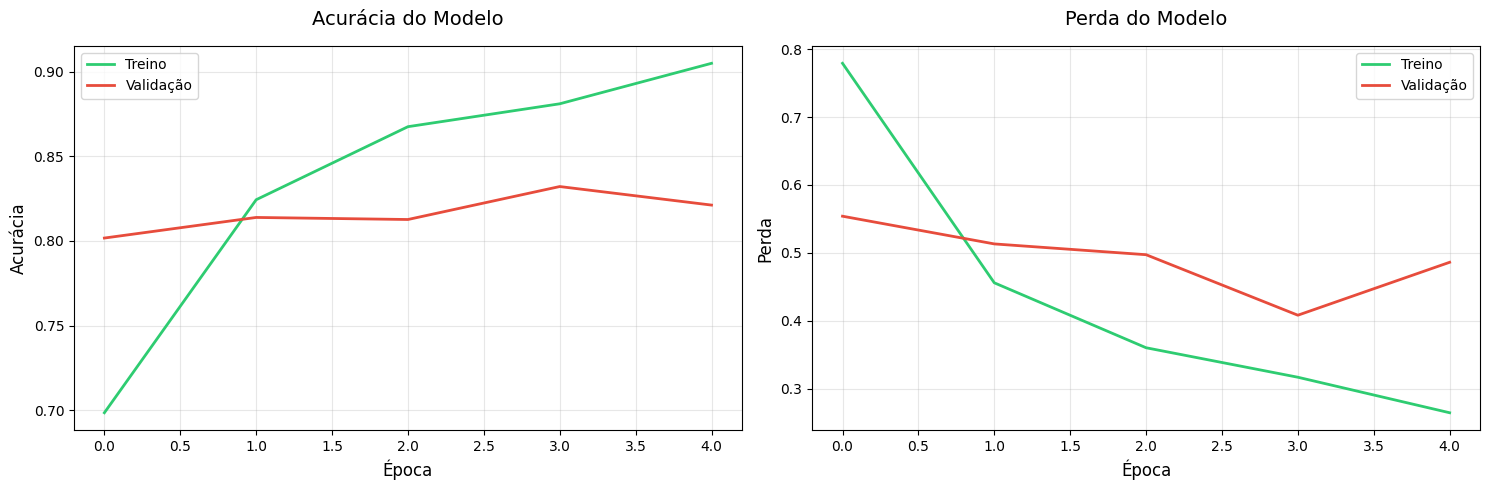

In [14]:
# Treinar o modelo com os splits padrão
main(train_split=0.7, val_split=0.15, test_split=0.15)